<a href="https://colab.research.google.com/github/nicolesaade/WorldHappinessReportAnalysis/blob/main/WorldHappinessReport_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. Predict 2023 Life Ladder

##3(a) Load Life Ladder Score



In [51]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

#Load data
data = pd.read_excel('happiness_dataset.xls')

#Normalize data
scaler = StandardScaler()
data['Life Ladder'] = scaler.fit_transform(data[['Life Ladder']])

#Dataframe with life ladder score 2005-2020
ladder_train = data[['Country name', 'year', 'Life Ladder']].loc[~data['year'].isin([2021, 2022, 2023])]

#Dataframe with life ladder score 2021-2023
ladder_test = data[['Country name', 'year', 'Life Ladder']].loc[data['year'].isin([2021, 2022, 2023])]

#Remove countries with 2005-2020 life ladder score for only one year
be_removed = ['Cuba', 'Guyana', 'Maldives', 'Oman', 'Suriname']
ladder_train = ladder_train.loc[~ladder_train['Country name'].isin(be_removed)]
ladder_test = ladder_test.loc[~ladder_test['Country name'].isin(be_removed)]

#Remove countries missing any of the 2021-2023 life ladder score
countries = set(ladder_test.loc[ladder_test['year']==2021]['Country name'].unique()).intersection(ladder_test.loc[ladder_test['year']==2022]['Country name'].unique(), ladder_test.loc[ladder_test['year']==2023]['Country name'].unique())
ladder_train = ladder_train.loc[ladder_train['Country name'].isin(countries)]
ladder_test = ladder_test.loc[ladder_test['Country name'].isin(countries)]

ladder_train.head(20)

,Country name,year,Life Ladder
0,Afghanistan,2008,-1.564024
1,Afghanistan,2009,-0.961343
2,Afghanistan,2010,-0.644443
3,Afghanistan,2011,-1.467934
4,Afghanistan,2012,-1.511284
5,Afghanistan,2013,-1.698647
6,Afghanistan,2014,-2.090730
7,Afghanistan,2015,-1.333625
8,Afghanistan,2016,-1.122733
9,Afghanistan,2017,-2.507671


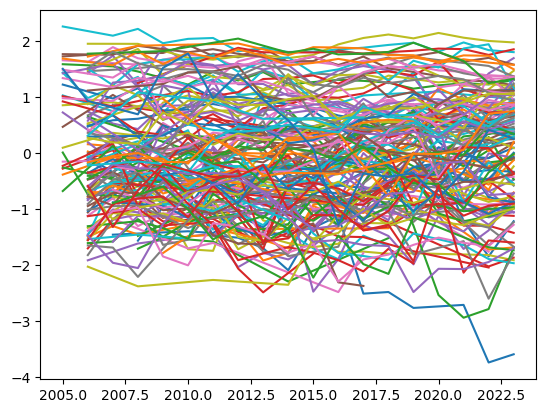

In [47]:
import matplotlib.pyplot as plt

for country in data['Country name'].unique():
  plt.plot(data.loc[data['Country name']==country]['year'], data.loc[data['Country name']==country]['Life Ladder'])

##3(b) Linear Regression

In [136]:
from sklearn.linear_model import LinearRegression

def predict_LinReg(country_name):
  X_train = ladder_train.loc[ladder_train['Country name']==country_name].loc[:, 'year'].values.reshape(-1, 1)
  X_test = ladder_test.loc[ladder_test['Country name']==country_name].loc[:, 'year'].values.reshape(-1, 1)
  y_train = ladder_train.loc[ladder_train['Country name']==country_name].loc[:, 'Life Ladder']
  y_test = ladder_test.loc[ladder_test['Country name']==country_name].loc[:, 'Life Ladder']

  model = LinearRegression().fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = model.score(X_test, y_test)

  return y_pred, score

LinReg_df = pd.DataFrame(columns=['Country name', '2021 True', '2021 Predicted',
                               '2022 True', '2022 Predicted','2023 True', '2023 Predicted', 'R^2 Score'])

for country in ladder_train['Country name'].unique():
  y_pred, score = predict_LinReg(country)
  LinReg_df.loc[len(LinReg_df.index)] = [country, ladder_test.loc[(ladder_test['Country name'] == country) & (ladder_test['year'] == 2021), 'Life Ladder'].values[0], y_pred[0],
                                               ladder_test.loc[(ladder_test['Country name'] == country) & (ladder_test['year'] == 2022), 'Life Ladder'].values[0], y_pred[1],
                                               ladder_test.loc[(ladder_test['Country name'] == country) & (ladder_test['year'] == 2023), 'Life Ladder'].values[0], y_pred[2], score]

LinReg_df.head(20)

,Country name,2021 True,2021 Predicted,2022 True,2022 Predicted,2023 True,2023 Predicted,R^2 Score
0,Afghanistan,-2.708228,-2.675499,-3.734425,-2.808415,-3.588117,-2.941331,-1.072112
1,Albania,-0.202687,-0.553307,-0.241138,-0.573210,-0.034544,-0.593112,-21.581373
2,Argentina,0.377430,0.602831,0.690875,0.586363,0.808387,0.569895,-0.194905
3,Armenia,-0.162620,-0.600158,-0.090306,-0.569359,0.173758,-0.538560,-13.805109
4,Australia,1.446777,1.524304,1.378437,1.514809,1.369449,1.505314,-11.040031
5,Austria,1.418377,1.552255,1.346712,1.550788,1.023831,1.549321,-2.799705
6,Bangladesh,-1.208800,-0.591695,-1.844893,-0.584678,-1.217482,-0.577660,-7.937339
7,Belgium,1.242525,1.145548,1.220413,1.121706,1.297482,1.097863,-17.730984
8,Benin,-0.879894,-0.476601,-1.125259,-0.361071,-0.945297,-0.245541,-37.287817
9,Bolivia,0.075591,0.294227,0.395740,0.303258,0.334425,0.312288,0.015675


In [140]:
from google.colab import drive
#!pip install pandas==2.0
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/DS Group Project/'
LinReg_df.to_csv(path+'LinReg.csv', index=False)

Mounted at /content/drive


##3(c) LSTM

In [129]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

def create_dataset(df):
  x = []
  y = []
  for i in range(df.shape[0]-2):
    x.append(df[i:i+2, 0])
    y.append(df[i+2, 0])
  x = np.array(x)
  y = np.array(y)
  return x,y

def predict_LSTM(country_name):
  X_train, y_train = create_dataset(ladder_train.loc[ladder_train['Country name']==country_name].loc[:, 'Life Ladder'].values.reshape(-1, 1))
  X_test, y_test = create_dataset(ladder_test.loc[ladder_test['Country name']==country_name].loc[:, 'Life Ladder'].values.reshape(-1, 1))

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  model = Sequential()
  model.add(LSTM(units=96, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(0.2)) #Drop 20% of the data
  model.add(LSTM(units=96, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train, y_train, epochs=100, batch_size=32)
  #epochs: number of tranings, each outputs a loss
  #The loss generally decreases but settles down
  #The loss sometimes increases as they explore new possibilities

  y_pred = model.predict(X_test)
  return y_pred[0]

In [131]:
LSTM_df = pd.DataFrame(columns=['Country name', '2023 True', '2023 Predicted', 'R^2 Score'])

for country in ladder_train['Country name'].unique():
  y_pred = predict_LSTM(country)[0]
  y_true = ladder_test.loc[(ladder_test['Country name'] == country) & (ladder_test['year'] == 2023), 'Life Ladder'].values[0]
  LSTM_df.loc[len(LSTM_df.index)] = [country, y_true, y_pred, (y_true-y_pred)**2]

LSTM_df.head(20)

Streaming output truncated to the last 5000 lines.
Epoch 14/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1891
Epoch 15/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1784
Epoch 16/100
1/1 [==============================] - 0s 24ms/step - loss: 0.1486
Epoch 17/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1335
Epoch 18/100
1/1 [==============================] - 0s 30ms/step - loss: 0.1091
Epoch 19/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0833
Epoch 20/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0662
Epoch 21/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0578
Epoch 22/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0563
Epoch 23/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0473
Epoch 24/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0635
Epoch 25/100
1/1 [==============================] - 0s 25ms/step - lo

,Country name,2023 True,2023 Predicted,R^2 Score
0,Afghanistan,-3.588117,-2.428320,1.345131
1,Albania,-0.034544,-0.316101,0.079274
2,Argentina,0.808387,0.645403,0.026564
3,Armenia,0.173758,-0.682106,0.732505
4,Australia,1.369449,1.515190,0.021241
5,Austria,1.023831,1.537662,0.264022
6,Bangladesh,-1.217482,-0.674802,0.294502
7,Belgium,1.297482,1.206177,0.008337
8,Benin,-0.945297,-0.890899,0.002959
9,Bolivia,0.334425,0.244187,0.008143


In [141]:
LSTM_df.to_csv(path+'LSTM.csv', index=False)

##3(d) Display Results

Text(0, 0.5, 'Predicted 2023 (LSTM)')

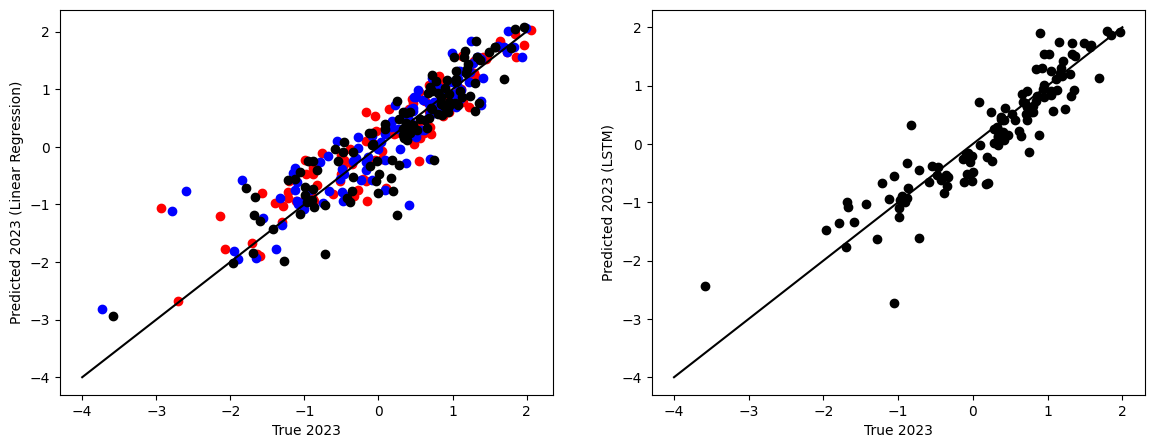

In [149]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(14,5))

axs[0].scatter(LinReg_df['2021 True'], LinReg_df['2021 Predicted'], c='r')
axs[0].scatter(LinReg_df['2022 True'], LinReg_df['2022 Predicted'], c='b')
axs[0].scatter(LinReg_df['2023 True'], LinReg_df['2023 Predicted'], c='k')
x = np.linspace(-4, 2, 400)
axs[0].plot(x, x, c='k')
axs[0].set_xlabel('True 2023')
axs[0].set_ylabel('Predicted 2023 (Linear Regression)')

axs[1].scatter(LSTM_df['2023 True'], LSTM_df['2023 Predicted'], c='k')
axs[1].plot(x, x, c='k')
axs[1].set_xlabel('True 2023')
axs[1].set_ylabel('Predicted 2023 (LSTM)')

Text(0.5, 1.0, 'R^2 Score (LSTM)')

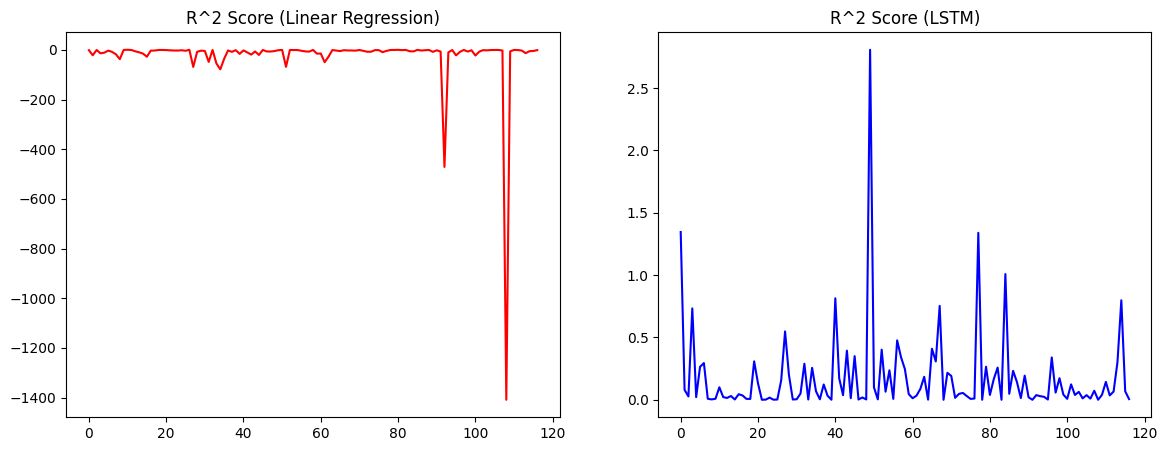

In [151]:
fig, axs = plt.subplots(1,2, figsize=(14,5))

axs[0].plot(LinReg_df['R^2 Score'], c='r')
axs[0].set_title('R^2 Score (Linear Regression)')

axs[1].plot(LSTM_df['R^2 Score'], c='b')
axs[1].set_title('R^2 Score (LSTM)')